In [1]:
#Basic shit
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

#Gurobi
import gurobipy as gp
from gurobipy import GRB

In [40]:
with open('Data/CAB/25.3.4') as f:
    CAB = f.read().splitlines()
nodes = int(CAB[0])
CAB = CAB[1::]
coords = []
for i in range(nodes):
    coords.append(Point(CAB[i].split(" ")))
CAB = CAB[nodes::]

st = "qwertyuiopasdfghjklzxcvbnm"
id_l = []
for i in range(nodes):
    id_l.append(st[i])
df_mother = pd.DataFrame(index=id_l)
for i in range(nodes):   
    df_mother[id_l[i]] = [float(x) for x in CAB[i].split(" ")]    
CAB = CAB[25::]
mother_coords = coords


In [41]:
N = 5

names = ["plane" + str(i) for i in range(1,N+1)]
planes_df = pd.DataFrame(index=names)
cap = [5,10,15,20,25]
cap.sort()
planes_df["cap"] = cap
planes_df["cost"] = [1 for i in range(N)]
planes_df["max_dist"] = [0.5*i for i in range(1,N+1)]
planes_df["land_cost"] = [1 for i in range(N)]

In [42]:
#add a zero plane:
zero_plane = pd.DataFrame(index=["noplane"])
zero_plane["cap"] = 0
zero_plane["cost"] = 0
zero_plane["max_dist"] = planes_df["max_dist"].max()
zero_plane["land_cost"] = 0
planes_df = pd.concat([zero_plane, planes_df], ignore_index=False)

In [58]:
time_list = []
size_list = [x for x in range(3,20)]
for size in size_list:
    id_l = df_mother.index.tolist()[0:size]
    df = pd.DataFrame(index = id_l)

    for col in df.index.tolist():
        df[col] = df_mother[col].tolist()[0:size]
    df["geometry"] = mother_coords[0:size]

    gdf = gpd.GeoDataFrame(df["geometry"], geometry='geometry')
    gdf.set_crs('EPSG:32120', inplace=True);

    for i in range(size):
        gdf[id_l[i]] = gdf.distance(gdf.geometry[i])     
    l = 500
    for col in df.columns.tolist()[0:-1]:
        df[col] = round(df[col]/l)
    l = 50
    for col in gdf.columns.tolist()[1::]:
        gdf[col] = round(df[col]/l, 2)
        #print(gdf[col].nsmallest(2).tolist()[1])

    gdf["total_flow"] = df.sum(axis=1, numeric_only=True)
    df.drop("geometry", axis=1, inplace=True)

    planes = [n for n in planes_df.index.tolist()]
    nodes = [i for i in df.index.tolist()]



    max_dist = planes_df["max_dist"].max()
    for node in nodes:
        min_dist = gdf[node].nsmallest(2).tolist()[-1]
        if min_dist > max_dist:
            print(node, "is to far away from the system")


    arcs = [(i,j) for i in nodes for j in nodes if i!=j] #check all arcs
    D_ij = {} #length of arc i,j
    N_ij = {} #planes available between i and j
    poss_arcs = [] #only use possible arcs
    for tup in arcs:
        dist_ij = gdf[tup[0]][tup[1]] #length of arc
        n_list = []
        for plane in planes: #check if there are any planes that 
            if planes_df["max_dist"][plane]>dist_ij:
                n_list.append(plane)
        if len(n_list) > 0:
            poss_arcs.append(tup)
            D_ij[tup] = dist_ij
            N_ij[tup] = n_list

    all_arcs = arcs
    arcs = poss_arcs #only use possible arcs

    commodities = [h for h in nodes]
    W_h_i = {} #demand of commodity h at node i

    for node in nodes:
        com = node
        total_flow_in = df.loc[node].sum()
        W_h_i[(com, node)] = -total_flow_in

        for com in nodes:
            if com != node:
                flow_out = df[node][com]
                W_h_i[(com,node)] = flow_out


    K_n = {}
    C_n = {}
    Cl_n = {}
    for plane in planes:
        K_n[plane] = planes_df["cap"][plane]
        C_n[plane] = planes_df["cost"][plane]
        Cl_n[plane] = planes_df["land_cost"][plane]


    arc_plane_n_ij = [(n,i,j) for (i,j) in arcs for n in N_ij[(i,j)]]

    C_n_ij = {}
    for (n,i,j) in arc_plane_n_ij:
        C_n_ij[(n,i,j)] = C_n[n]*D_ij[(i,j)]


    CN_ij = {} #continous cost
    KN_ij = {} #

    for arc in arcs:
        if len(N_ij[arc])>0:
            plane = N_ij[arc][-1]
            KN_ij[arc] = K_n[plane]
            P_N = C_n[plane]*D_ij[arc]#/K_n[plane]
            CN_ij[arc] = P_N
        else:
            KN_ij[arc] = 0
            CN_ij[arc] = 0



    M = 1
    for node in nodes:
        od = df[node].sum()
        M += od
    M = max(max(KN_ij.values()), M) + 1


    #model
    try:
        m = gp.Model("airfleet")

        ###Variables:


        # Create variables
        f = m.addVars(commodities, arcs, name="F")
        g = m.addVars(arcs, vtype=GRB.BINARY, name="G") 
        a = m.addVars(arc_plane_n_ij, vtype=GRB.BINARY, name="A")
        ag = m.addVars(arcs, vtype=GRB.INTEGER, name="AG")
        u = m.addVars(arcs, name="U")
        u_help = m.addVars(arcs, lb=-M, name="U_help")
        f_arc = m.addVars(arcs, name = "farc")
        z_help = m.addVars(arcs, name="z_help") 
        hub_help = m.addVars(nodes, name="hub_help")
        hub = m.addVars(nodes, vtype=GRB.BINARY, name="hub")


        obj = a.prod(C_n_ij) + ag.prod(CN_ij) 
        #+ sum(sum(Cl_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs)


        #Objective function (a)
        m.setObjective(obj, GRB.MINIMIZE)

        # Flow-conservation constraints
        m.addConstrs(
            (f.sum(h, '*', i) + W_h_i[h, i] == f.sum(h, i, '*')
             for h in commodities for i in nodes), "node")

        #F assign total flow on arc
        m.addConstrs((f_arc[i,j] == f.sum("*", i, j) for (i,j) in arcs), "H")

        #A pick a plane
        m.addConstrs((f_arc[i,j] <= sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) + ag[i,j] for (i,j) in arcs), "9b") # ensure flow < capacity of the chosen plane
        m.addConstrs((sum(a[n,i,j] for n in N_ij[(i,j)]) + g[i,j] == 1 for (i,j) in arcs), "9a") # pick ONE plane OR pick g

        m.addConstrs(M*g[i,j] >= ag[i,j] for (i,j) in arcs)

        #fly the plane back
        #this will become infeasible when symmetry is not ensured
        m.addConstrs(a[n,i,j] == a[n,j,i] for (n,i,j) in arc_plane_n_ij)

        m.optimize()
        #for v in m.getVars():
        #    print('%s %g' % (v.VarName, v.X))

        print('Obj: %g' % m.ObjVal)

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')


    print("\n\n ****** \n\n")
    print(size, m.runtime)
    print("\n\n ****** \n\n")
    time_list.append(m.runtime)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 67 rows, 94 columns and 220 nonzeros
Model fingerprint: 0xa661c06f
Variable types: 45 continuous, 49 integer (43 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e-01, 5e-01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective 57.2800000
Presolve removed 46 rows and 67 columns
Presolve time: 0.00s
Presolved: 21 rows, 27 columns, 78 nonzeros
Variable types: 18 continuous, 9 integer (3 binary)

Root relaxation: objective 1.715200e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.71520    0    2   57.28000    1.71520  97.0% 

Thread count was 4 (of 4 available processors)

Solution count 2: 235.92 1048.72 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.359200000000e+02, best bound 2.359200000000e+02, gap 0.0000%
Obj: 235.92


 ****** 


6 0.3826181888580322


 ****** 


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 449 rows, 792 columns and 2020 nonzeros
Model fingerprint: 0x5dee739d
Variable types: 469 continuous, 323 integer (281 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1289.2200000
Presolve removed 316 rows and 435 columns
Presolve time: 0.00s
Presolved: 133 rows, 357 columns, 1050 nonzeros
Variable types: 294 continuous, 63 integer (21 binary)

Root relaxation: obje

     0     0  391.27627    0   27  548.52000  391.27627  28.7%     -    0s
     0     0  391.31724    0   34  548.52000  391.31724  28.7%     -    0s
     0     0  391.31738    0   34  548.52000  391.31738  28.7%     -    0s
     0     0  391.60386    0   33  548.52000  391.60386  28.6%     -    0s
     0     0  391.63205    0   31  548.52000  391.63205  28.6%     -    0s
     0     0  391.63266    0   31  548.52000  391.63266  28.6%     -    0s
     0     0  391.75876    0   34  548.52000  391.75876  28.6%     -    0s
     0     0  391.75876    0   34  548.52000  391.75876  28.6%     -    0s
     0     0  392.25605    0   34  548.52000  392.25605  28.5%     -    0s
H    0     0                     547.2000000  392.25605  28.3%     -    0s
     0     0  392.31673    0   34  547.20000  392.31673  28.3%     -    0s
     0     0  392.68768    0   33  547.20000  392.68768  28.2%     -    0s
     0     0  392.69018    0   37  547.20000  392.69018  28.2%     -    0s
     0     0  397.98931  

H  265   110                     423.8000000  420.23574  0.84%  30.4    1s
H  280   110                     422.0400000  420.23574  0.43%  29.8    1s
H  284   106                     421.8400000  420.28576  0.37%  29.4    1s
H  285   106                     421.3200000  420.28576  0.25%  29.4    1s
H  320   110                     421.0800000  420.49592  0.14%  29.2    1s
H  321   110                     420.9200000  420.50234  0.10%  29.2    1s

Cutting planes:
  Gomory: 6
  Implied bound: 5
  MIR: 36
  Inf proof: 1

Explored 486 nodes (12084 simplex iterations) in 1.28 seconds (0.59 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 420.92 421.08 421.32 ... 534.24

Optimal solution found (tolerance 1.00e-04)
Best objective 4.209200000000e+02, best bound 4.209200000000e+02, gap 0.0000%
Obj: 420.92


 ****** 


11 1.3062081336975098


 ****** 


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
T


     0     0  712.19184    0   34 6403.68000  712.19184  88.9%     -    0s
H    0     0                    6371.8400000  712.19184  88.8%     -    0s
     0     0  744.00750    0   40 6371.84000  744.00750  88.3%     -    0s
     0     0  744.15424    0   42 6371.84000  744.15424  88.3%     -    0s
     0     0  757.42664    0   43 6371.84000  757.42664  88.1%     -    0s
     0     0  757.78021    0   44 6371.84000  757.78021  88.1%     -    0s
     0     0  757.78423    0   43 6371.84000  757.78423  88.1%     -    0s
     0     0  758.49244    0   44 6371.84000  758.49244  88.1%     -    0s
     0     0  758.55975    0   45 6371.84000  758.55975  88.1%     -    0s
     0     0  758.60576    0   45 6371.84000  758.60576  88.1%     -    0s
     0     0  758.60578    0   45 6371.84000  758.60578  88.1%     -    0s
     0     0  760.13004    0   43 6371.84000  760.13004  88.1%     -    0s
     0     0  760.25498    0   52 6371.84000  760.25498  88.1%     -    0s
     0     0  760.25651 

H   19    23                     886.3600000  855.91262  3.44%   159    2s
H   25    29                     867.6400000  855.91262  1.35%   147    2s
H   31    27                     866.9600000  855.91262  1.27%   120    2s
H   79    43                     865.9600000  856.82337  1.06%  88.9    3s
H   85    47                     865.8400000  856.82337  1.04%  86.9    3s
H   86    47                     865.2400000  856.82337  0.97%  86.0    3s
H   90    48                     864.8000000  856.82337  0.92%  86.3    3s
H  102    55                     864.4400000  856.82337  0.88%  83.4    3s
H  112    58                     864.4000000  857.79739  0.76%  78.3    3s
H  114    58                     863.8400000  857.79739  0.70%  77.8    3s
H  118    61                     863.4000000  857.79739  0.65%  78.3    3s
H  119    61                     863.3600000  857.79739  0.64%  77.8    3s
H  124    66                     863.0400000  857.79739  0.61%  76.5    3s
H  129    77             

H  487    60                    3192.0400000 3191.67211  0.01%  65.7    7s
*  488    60              32    3192.0000000 3191.67211  0.01%  65.6    7s

Cutting planes:
  Gomory: 13
  Implied bound: 36
  MIR: 40

Explored 641 nodes (36611 simplex iterations) in 7.96 seconds (4.74 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 3192 3192.04 3192.08 ... 3192.8

Optimal solution found (tolerance 1.00e-04)
Best objective 3.192000000000e+03, best bound 3.192000000000e+03, gap 0.0000%
Obj: 3192


 ****** 


17 8.02030897140503


 ****** 


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3106 rows, 8698 columns and 23770 nonzeros
Model fingerprint: 0xe428818e
Variable types: 6486 continuous, 2212 integer (1918 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e-02, 2

In [57]:
time_list

[0.1050271987915039, 0.2530529499053955, 0.7338171005249023]

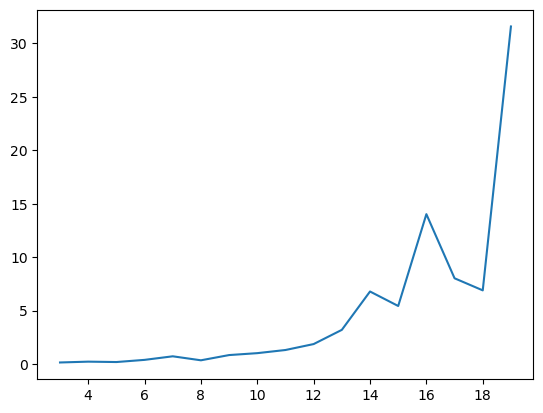

In [59]:
plt.plot(size_list,time_list)